# Gradient Boosting with categorical features
In this example we try to predict the chances of survival of the passengers of the Titanic. Since the dataset contains many categorical features, we use CatBoost as an implementation for the gradient boosting method.

## Install missing packages

In [1]:
!pip install -q catboost

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


## Import needed packages

In [114]:
import catboost.datasets
import numpy as np
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd

## Load the Titanic dataset

In [96]:
train_df, test_df = catboost.datasets.titanic()
print(f"Number of samples: training: {len(train_df.index)} / testing: {len(test_df.index)}")
print("\nSome training examples:")
train_df.head()

Number of samples: training: 891 / testing: 418

Some training examples:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Prepare the dataset
### Check for missing values
We replace missing vales with a default value of -999

In [97]:
null_value_stats = train_df.isnull().sum(axis=0)
print(f"Number of missing items per feature:\n{null_value_stats[null_value_stats != 0]}")

#As we can see, Age, Cabin and Embarked indeed have some missing values, so let's fill them with some number way out of their distributions - so the model would be able to easily distinguish between them and take it into account:
train_df.fillna(-999, inplace=True)
test_df.fillna(-999, inplace=True)

Number of missing items per feature:
Age         177
Cabin       687
Embarked      2
dtype: int64


### separate features and label variable

In [98]:
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

### Check for categorical features

In [102]:
print(f"Feature datatypes: \n{X.dtypes}")
print(f"\nFeature unique values: \n{X.nunique()}")

Feature datatypes: 
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Feature unique values: 
PassengerId    891
Pclass           3
Name           891
Sex              2
Age             89
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          148
Embarked         4
dtype: int64


### Save the columns indicies with categorical characteristics

In [35]:
categorical_features_indices = np.where(X.dtypes != float)[0]
categorical_features_indices

array([ 0,  1,  2,  3,  5,  6,  7,  9, 10])

### Create a train and validation split

In [36]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
X_test = test_df

## Train the model

In [65]:
# init the CatBoostClassifier
model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)

# train the classifier
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    #logging_level='Verbose',  # you can uncomment this for text output
    plot=False,
    use_best_model=True
);

# get the best iteration index
best_iteration = model.get_best_iteration()

## Plot the training progress

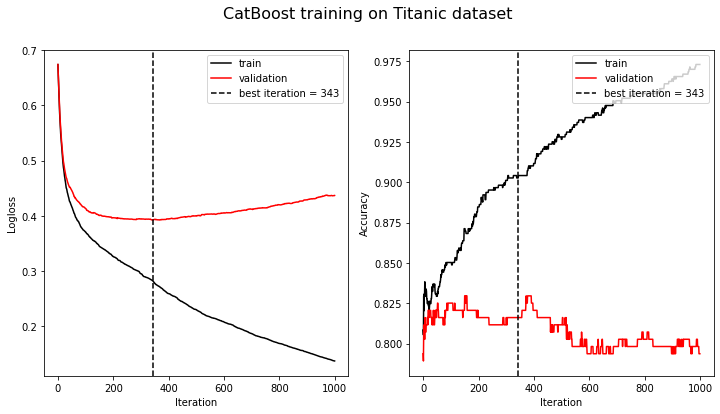

Best scores: {'learn': {'Accuracy': 0.9730538922155688, 'Logloss': 0.1375022706580763}, 'validation': {'Accuracy': 0.8295964125560538, 'Logloss': 0.3925688672521046}}


In [110]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
ax1.plot(model.get_evals_result()['learn']['Logloss'],'k-',label="train")
ax1.plot(model.get_evals_result()['validation']['Logloss'],'r-',label="validation")
ax1.axvline(best_iteration, color='k', ls='--',label = f'best iteration = {best_iteration}')
ax1.legend(loc="upper right")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Logloss")

ax2.plot(model.get_evals_result()['learn']['Accuracy'],'k-',label="train")
ax2.plot(model.get_evals_result()['validation']['Accuracy'],'r-',label="validation")
ax2.axvline(best_iteration, color='k', ls='--',label = f'best iteration = {best_iteration}')
ax2.legend(loc="upper right")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
f.suptitle('CatBoost training on Titanic dataset', fontsize=16);
plt.show()

print(f"Best scores: {model.get_best_score()}")


## Get the Feature Importances

In [128]:
feature_importances = model.get_feature_importance()
feature_names = X_train.columns
df = pd.DataFrame(zip(feature_names,feature_importances),columns=['feature','importance'])
df.set_index('feature',inplace=True)
df.sort_values('importance',ascending=False)

,importance
feature,
Sex,26.414281
Pclass,17.051485
Parch,10.353779
Age,10.048602
Embarked,8.904411
Cabin,7.919649
SibSp,7.745335
Fare,5.797149
Ticket,5.765309


## Plot the model

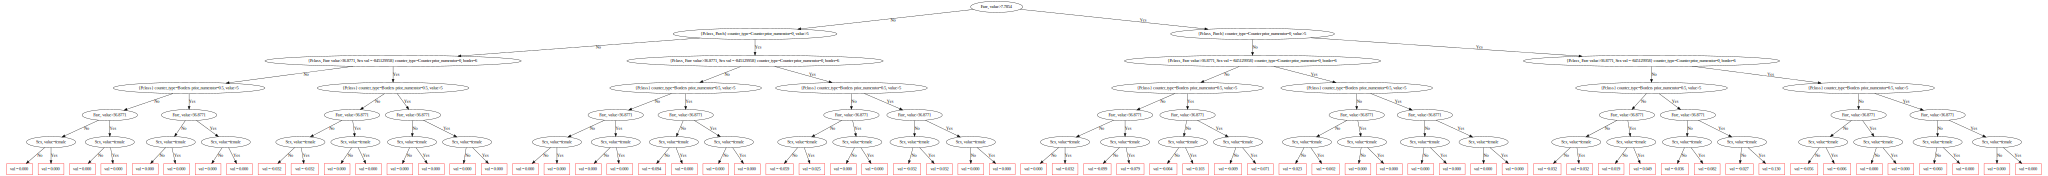

In [129]:
model.plot_tree(0,X_train)